### Importing required Libraries

In [28]:
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import accuracy_score, classification_report

In [29]:
train_dir = '../data/splitted-blood-cells/train'
test_dir = '../data/splitted-blood-cells/test'
val_dir = '../data/splitted-blood-cells/val'

### Loading the Image Data
For this we will be using generators as they prevent us from loading all the images from the disk at the same time which might crash the notebook. Generators will load them few at a time, train on them and then recycle the memory to continue the process again.

We will be using a pre trained model called "MobileNetV2" which is a Convolutional Neural Network that was trained on the image net dataset which is considered good for extracting features

In [30]:
# Create generators

train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
)

test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

val_gen =  tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

### How we are going to transform the images from the directories into the notebook

In [31]:
#  Flow image data

train_images = train_gen.flow_from_directory(
    directory=train_dir,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = val_gen.flow_from_directory(
    directory=val_dir,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42
#     subset='validation'
)

test_images = test_gen.flow_from_directory(
    directory=test_dir,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    seed=42
)

Found 13671 images belonging to 8 classes.
Found 850 images belonging to 8 classes.
Found 2571 images belonging to 8 classes.


### Build Pretrained Model

In [32]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3), # this is the prescribed dimension of images in the mobilenet documentation
    include_top=False, # take off the classification part of the pre trained model
    # so we are just going to use this model as a feature extractor. So, once we
    # extract the features we will include our own classifier model
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False # we don't want it to train it the way its assoicated with the model

### Build Classification Model

In [33]:
inputs = pretrained_model.input
x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
outputs = tf.keras.layers.Dense(8, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(model.summary())

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________________

In [34]:
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=5,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/5
428/428 [==============================] - 302s 706ms/step - loss: 0.4156 - accuracy: 0.8628 - val_loss: 0.2621 - val_accuracy: 0.9118
Epoch 2/5
428/428 [==============================] - 396s 924ms/step - loss: 0.2144 - accuracy: 0.9261 - val_loss: 0.2115 - val_accuracy: 0.9247
Epoch 3/5
428/428 [==============================] - 339s 793ms/step - loss: 0.1654 - accuracy: 0.9424 - val_loss: 0.2044 - val_accuracy: 0.9365
Epoch 4/5
428/428 [==============================] - 667s 2s/step - loss: 0.1437 - accuracy: 0.9523 - val_loss: 0.2523 - val_accuracy: 0.9259
Epoch 5/5
428/428 [==============================] - 327s 764ms/step - loss: 0.1206 - accuracy: 0.9579 - val_loss: 0.2453 - val_accuracy: 0.9235


In [35]:
fig = px.line(
    history.history,
    y=['loss', 'val_loss'],
    labels={'index': "Epoch", 'value': "Loss"},
    title="Training and Validation Loss Over Time"
)

fig.show()

In [36]:
CLASS_NAMES = list(train_images.class_indices.keys())
CLASS_NAMES

['basophil',
 'eosinophil',
 'erythroblast',
 'ig',
 'lymphocyte',
 'monocyte',
 'neutrophil',
 'platelet']

Test Accuracy: 92.221%


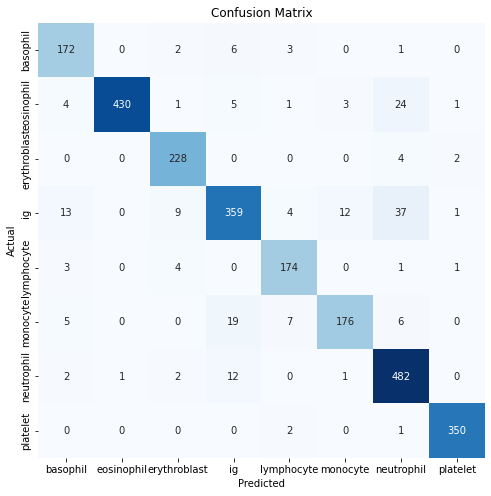

Classification Report:
----------------------
               precision    recall  f1-score   support

    basophil       0.86      0.93      0.90       184
  eosinophil       1.00      0.92      0.96       469
erythroblast       0.93      0.97      0.95       234
          ig       0.90      0.83      0.86       435
  lymphocyte       0.91      0.95      0.93       183
    monocyte       0.92      0.83      0.87       213
  neutrophil       0.87      0.96      0.91       500
    platelet       0.99      0.99      0.99       353

    accuracy                           0.92      2571
   macro avg       0.92      0.92      0.92      2571
weighted avg       0.92      0.92      0.92      2571



In [37]:
predictions = np.argmax(model.predict(test_images), axis=1)

acc = accuracy_score(test_images.labels, predictions)
cm = tf.math.confusion_matrix(test_images.labels, predictions)
clr = classification_report(test_images.labels, predictions, target_names=CLASS_NAMES)

print("Test Accuracy: {:.3f}%".format(acc * 100))

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks= np.arange(8) + 0.5, labels=CLASS_NAMES)
plt.yticks(ticks= np.arange(8) + 0.5, labels=CLASS_NAMES)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)

Found 13671 images belonging to 8 classes.
Validation Accuracy: 96.401%


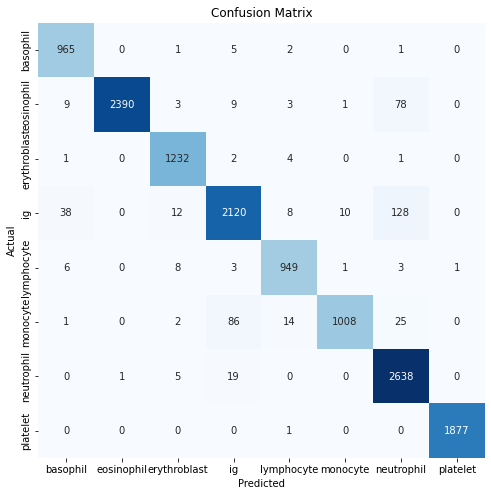

Classification Report:
----------------------
               precision    recall  f1-score   support

    basophil       0.95      0.99      0.97       974
  eosinophil       1.00      0.96      0.98      2493
erythroblast       0.98      0.99      0.98      1240
          ig       0.94      0.92      0.93      2316
  lymphocyte       0.97      0.98      0.97       971
    monocyte       0.99      0.89      0.94      1136
  neutrophil       0.92      0.99      0.95      2663
    platelet       1.00      1.00      1.00      1878

    accuracy                           0.96     13671
   macro avg       0.97      0.96      0.97     13671
weighted avg       0.97      0.96      0.96     13671



In [38]:
val_images = val_gen.flow_from_directory(
    directory=train_dir,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    seed=42,
#     subset='validation'
)


predictions = np.argmax(model.predict(val_images), axis=1)

acc = accuracy_score(val_images.labels, predictions)
cm = tf.math.confusion_matrix(val_images.labels, predictions)
clr = classification_report(val_images.labels, predictions, target_names=CLASS_NAMES)

print("Validation Accuracy: {:.3f}%".format(acc * 100))

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks= np.arange(8) + 0.5, labels=CLASS_NAMES)
plt.yticks(ticks= np.arange(8) + 0.5, labels=CLASS_NAMES)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)

Train Accuracy: 14.403%


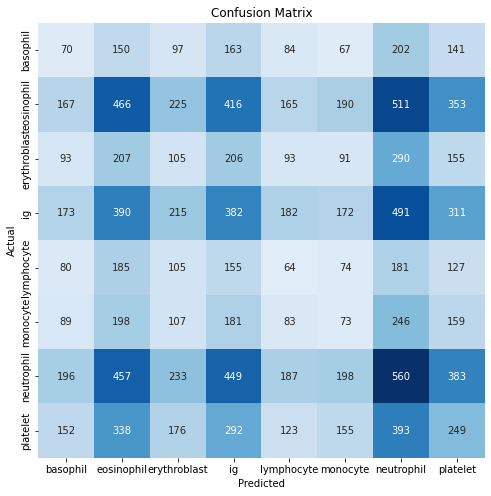

Classification Report:
----------------------
               precision    recall  f1-score   support

    basophil       0.07      0.07      0.07       974
  eosinophil       0.19      0.19      0.19      2493
erythroblast       0.08      0.08      0.08      1240
          ig       0.17      0.16      0.17      2316
  lymphocyte       0.07      0.07      0.07       971
    monocyte       0.07      0.06      0.07      1136
  neutrophil       0.19      0.21      0.20      2663
    platelet       0.13      0.13      0.13      1878

    accuracy                           0.14     13671
   macro avg       0.12      0.12      0.12     13671
weighted avg       0.14      0.14      0.14     13671



In [39]:
predictions = np.argmax(model.predict(train_images), axis=1)

acc = accuracy_score(train_images.labels, predictions)
cm = tf.math.confusion_matrix(train_images.labels, predictions)
clr = classification_report(train_images.labels, predictions, target_names=CLASS_NAMES)

print("Train Accuracy: {:.3f}%".format(acc * 100))

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks= np.arange(8) + 0.5, labels=CLASS_NAMES)
plt.yticks(ticks= np.arange(8) + 0.5, labels=CLASS_NAMES)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)